# Sliding pendulum system, with control

Consider the system composed of a simple pendulum of length $l$ and mass $m$ concentrated at its bob. The pivot of the pendulum is attached to a chariot of mass $m_o$ concentrated at its centre, sliding along a horizontal rail and submitted to a lateral control force field $\zeta$, possibly depending on time. The system is submitted to a uniform, constant gravitational acceleration field $g$ and moves without friction.

The generalised coordinate of the system is the position $x$ of the pivot on the rail and angle $\theta$ of the pendulum with the downward vertical direction. The standard (Cartesian) coordinates of the bob are then given by

\begin{equation*}
x_b = x+l\sin\theta
\hspace{2cm}
y_b = -l\cos\theta
\end{equation*}

The active forces are weight on the bob ($V_{(b)}=mgy$) and control on the pivot ($V_{(p)}=-\zeta x$). Hence the Lagrangian

\begin{eqnarray*}
\mathcal{L} & = & \frac{1}{2}(m_ox^2+m(\dot{x}^2+l^2\dot{\theta}^2+2l\dot{x}\dot{\theta}\cos\theta))+\zeta x+mgl\cos\theta\\
& = & \frac{1}{2}(m_o+m)\dot{x}^2+\frac{1}{2}m l^2\dot{\theta}^2+ml\dot{x}\dot{\theta}\cos\theta+\zeta x+mgl\cos\theta
\end{eqnarray*}

The equations of the dynamics are given by:

\begin{equation*}
\begin{array}{rrcl}
\left[\frac{\mathbf{d}}{\mathbf{d}t}\frac{\partial\mathcal{L}}{\partial\dot{x}} = \frac{\partial\mathcal{L}}{\partial x}\right]
\hspace{1cm} &
(m_o+m)\ddot{x}+ml\ddot{\theta}\cos\theta & = & \zeta+ml\dot{\theta}^2\sin\theta
\\
\left[\frac{\mathbf{d}}{\mathbf{d}t}\frac{\partial\mathcal{L}}{\partial\dot{\theta}} = \frac{\partial\mathcal{L}}{\partial\theta}\right]
\hspace{1cm} &
\ddot{x}\cos\theta+l\ddot{\theta} & = & -g\sin\theta
\end{array}
\end{equation*}

which can be rewritten as

\begin{equation*}
\left\{
\begin{array}{rcl}
a\ddot{x}+l\ddot{\theta}\cos\theta & = & u
\\
\ddot{x}\cos\theta+l\ddot{\theta} & = & v
\end{array}
\right.
\hspace{1cm}\textrm{where}\hspace{1cm}
\left|
\begin{array}{l}
a \triangleq 1+\frac{m_o}{m}
\\
u \triangleq \frac{\zeta}{m}+l\dot{\theta}^2\sin\theta
\hspace{1cm}
v \triangleq -g\sin\theta
\end{array}
\right.
\end{equation*}

The solution in $\ddot{x},\ddot{\theta}$ is therefore

\begin{equation*}
\left\{
\begin{array}{rcl}
\ddot{x} & = &
\frac{u-v\cos\theta}{a-\cos^2\theta}
\\
\ddot{\theta} & = &
\frac{av-u\cos\theta}{l(a-\cos^2\theta)}
\end{array}
\right.
\end{equation*}



Documentation: [here](../doc/_build/html/odesimu.html)

In [1]:
%pylab notebook
# for external animation (less resource consuming), use appropriate backend, e.g. qt5

import logging
from functools import partial
from scipy.integrate import quad
from ipyshow.util import Setup
from ipyshow.odesimu import System
from ipyshow.odesimu.util import DPiecewiseFunc, buffered, blurred, logger_hook, PIDController, marker_hook

Populating the interactive namespace from numpy and matplotlib


## ControlledPendulum class

In [2]:
#----------------------------------------------------------------------------------------------------
class ControlledPendulum (System):
#----------------------------------------------------------------------------------------------------

  shadowshape = (2,)

  #integrator = dict(name='dopri5')
  integrator = dict(name='dop853')

  @Setup(
    'Mo,M: mass of the chariot and the bob [kg]',
    'L: length of pendulum [m]',
    'G: intensity of the gravity [m.sec^-2]',
    'control: (lateral) control force field (instance of Controller class)',
  )
  def __init__(self,control,Mo,M,L,G):
    self.Mo, self.M, self.L, self.G = Mo, M, L, G
    self.control = control
    def main(t,state,a=1+Mo/M):
      x,θ,xʹ,θʹ = state
      sinθ, cosθ = sin(θ), cos(θ)
      u = control(t)[0]/M+L*square(θʹ)*sinθ
      v = -G*sinθ
      D = a-square(cosθ)
      xʺ = (u-v*cosθ)/D
      θʺ = (a*v-u*cosθ)/(L*D)
      return array((xʹ,θʹ,xʺ,θʺ))
    self.main = main
    def fordisplay(state,a=1+Mo/M):
      x,θ,xʹ,θʹ = state
      live = x, (x+L*sin(θ),-L*cos(θ))
      return live, live[1]
    self.fordisplay = fordisplay

  def runstep(self,crate=None,ini=None,**ka):
    self.control.reset(ini)
    t0 = T = 1/crate
    for t,y,realtime in super().runstep(ini=ini,**ka):
      if t>t0: self.control.update(t,y); t0 += T
      yield t,y,realtime

  def display(self,ax,refsize=None,**ka):
    Lx,Ly = 4*self.L,1.1*self.L
    ax.set_ylim(-Ly,Ly)
    ax.set_xlim(-Lx,Lx)
    ax.axhline(0,c='k')
    mo,m = self.Mo,self.M
    r = clip(sqrt(mo/m),1./refsize,refsize)
    sz = (refsize*r,refsize/r)
    diag_l, = ax.plot((),(),'k')
    diag_s = ax.scatter((0,0),(0,0),s=sz,marker='o',c=('b','r'))
    tail_l, = ax.plot((),(),'y')
    ax.set_title(r'trajectory:cahotic')
    def disp(t,live,tail,Lx=2*self.L):
      x,(xb,yb) = live
      diag_l.set_data((x,xb),(0,yb))
      diag_s.set_offsets(((x,0),(xb,yb),))
      tail_l.set_data(tail[:,0],tail[:,1])
      xr = ax.get_xlim()
      if x>xr[1]: ax.set_xlim(xr[0]+Lx,xr[1]+Lx)
      elif x<xr[0]: ax.set_xlim(xr[0]-Lx,xr[1]-Lx)
    return super().display(ax,disp,**ka)

  @staticmethod
  @Setup(
    'x: position of the pivot [m]',
    'xʹ: speed of the pivot [m.sec^-1]',
    'θ: angle of the pendulum with downward vertical [deg]',
    'θʹ: angular speed of pendulum [deg.sec^-1]',
    x=0.,xʹ=0.,θ=0.,θʹ=0.
  )
  def makestate(x,θ,xʹ,θʹ):
    return array((x,radians(θ),xʹ,radians(θʹ)))

  @Setup(
    'refsize: average size (area) of the bob and pivot for display [pt^2]',
    'crate: control rate',
    taild=20.,refsize=60.,hooks=(partial(logger_hook,logger=logging.getLogger()),)
  )
  def launch(self,*a,**ka): return super().launch(*a,**ka)

In [3]:
Setup.display(ControlledPendulum,PIDController)

**** ControlledPendulum.__init__(self, control, Mo, M, L, G) ****
    Mo,M      : mass of the chariot and the bob [kg]
    L         : length of pendulum [m]
    G         : intensity of the gravity [m.sec^-2]
    control   : (lateral) control force field (instance of Controller class) []
**** ControlledPendulum.launch(self, *a, **ka) ****
    maxtime   (inf       ): total simulation time length [sec]
    srate     (25.0      ): sampling rate [sec^-1]
    taild     (20.0      ): shadow duration [sec]
    hooks     ((functools): tuple of display hooks []
    ini       : initial state []
    refsize   (60.0      ): average size (area) of the bob and pivot for display [pt^2]
    crate     : control rate []
**** ControlledPendulum.makestate(x, θ, xʹ, θʹ) ****
    x         (0.0       ): position of the pivot [m]
    xʹ        (0.0       ): speed of the pivot [m.sec^-1]
    θ         (0.0       ): angle of the pendulum with downward vertical [deg]
    θʹ        (0.0       ): angular speed of pendulum [deg.sec^-1]
**** PIDController.__init__(self, gP, gI, gD, observe, target, **ka) ****
    N         : size of the buffer of change points []
    gP,gI,gD  (0.0,0.0,0.0): control gains (proportional, integral, derivative) []
    observe   : observation function []
    target    : target function []

<IPython.core.display.Javascript object>


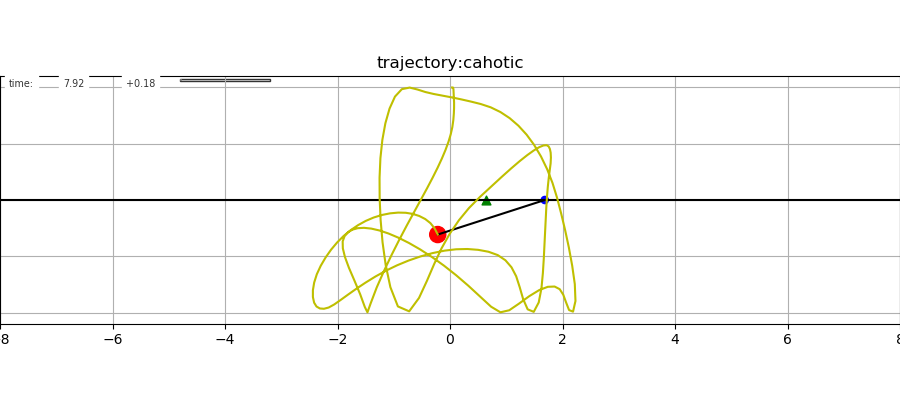

In [9]:
logging.basicConfig(level='WARN') # can be changed dynamically by logger_hook

period=2
def sintarget(t,R=1.,omega=2*pi/period):
  p = omega*t
  return R*sin(p)
def sinsintarget(t,R=1.,k=3.,omega=2*pi/period):
  p = omega*t
  return R*sin(p)*sin(p/k)

#target = buffered(T=period,N=int(100*period))(partial(sintarget,R=3.))
target = buffered(T=period,N=int(100*period))(partial(sinsintarget,R=3.,k=5.5))
#target = lambda t: 0
#target = buffered(T=period,N=int(100*period))(lambda t: t+2*sin(t))
control = PIDController(
  N=2,
  #gP=6.,
  gP=.5,
  #gI=1.,
  gD=10.,
  #gD=7.,
  target=blurred(0.05,shape=(1,))(target),
  observe=(lambda state=zeros((4,)):state[:1]),
  )

syst = ControlledPendulum(control,Mo=1,M=5,L=2,G=9.81)
syst.launch(
  fig=dict(figsize=(9,4)),
  ini=syst.makestate(θ=179.),
  crate=5.,
  hooks=(partial(marker_hook,f=(lambda t: (target(t),0.)),marker='^',s=40,c='g'),partial(logger_hook,logger=logging.getLogger())),
  )